# How to recover artifical signals from lightcurves

In addition to tools that inject artifical signals into Kepler, K2, and TESS lightcurves, `lightcurve` also includes tools to recover signals (real or injected).  In this notebook, we will recover signals of an injected supernova and an injected planet.

**SOME TEMPORARY NOTES:**

We want to be able to inject and recover with either a LightCurve object or a SyntheticLightCurve object.

So, do we want to put the "pointer" methods (the methods that live in the LightCurve or SyntheticLightCurve classes but point to lightkurve.injection) in both LC and SLC classes?

Right now, `.recover` is in SyntheticLightCurve and `.inject` is in LightCurve.

**ALSO: WRITE DOCSTRINGS!!!**


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import lightkurve.injection as inj
from lightkurve.lightcurve import SyntheticLightCurve

# Fitting a Supernova Signal

Let's download a TPF of a K2 galaxy and create the light curve.  We won't normalize it, because knowing the background flux is important in the fitting process.

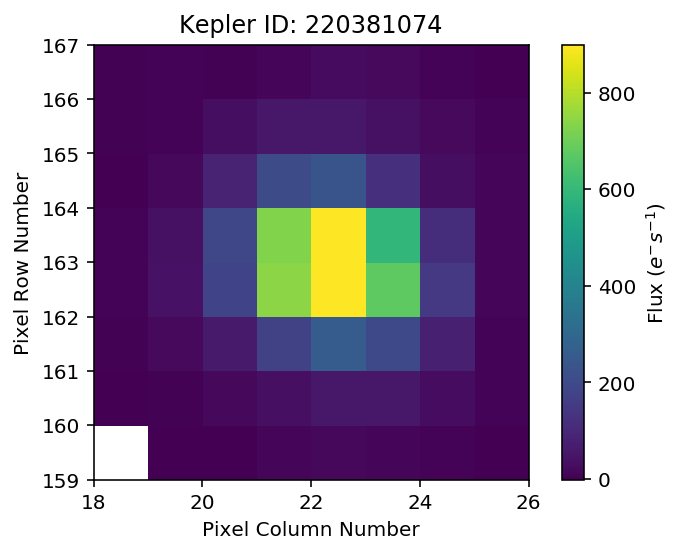

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

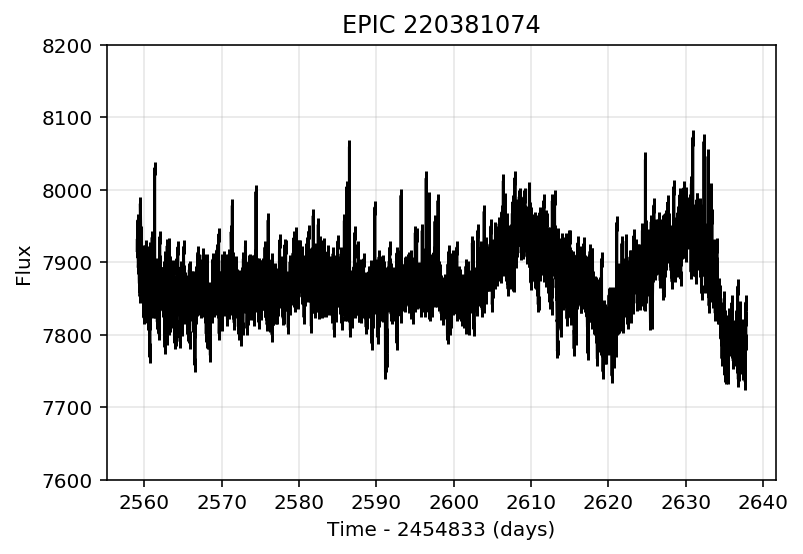

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [4]:
from lightkurve.injection import SupernovaModel

In [5]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)

In [6]:
lcinj = lc.inject(model)

Let's plot the model by itself (by evaluating it over the initial lightcurve's timestamps):

Text(0,0.5,'Flux')

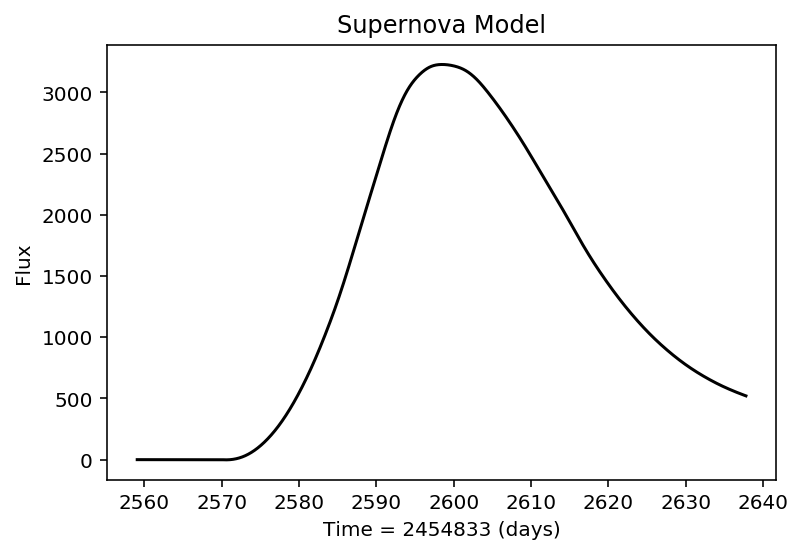

In [7]:
model_sn_eval = model.evaluate(lc.time)

plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

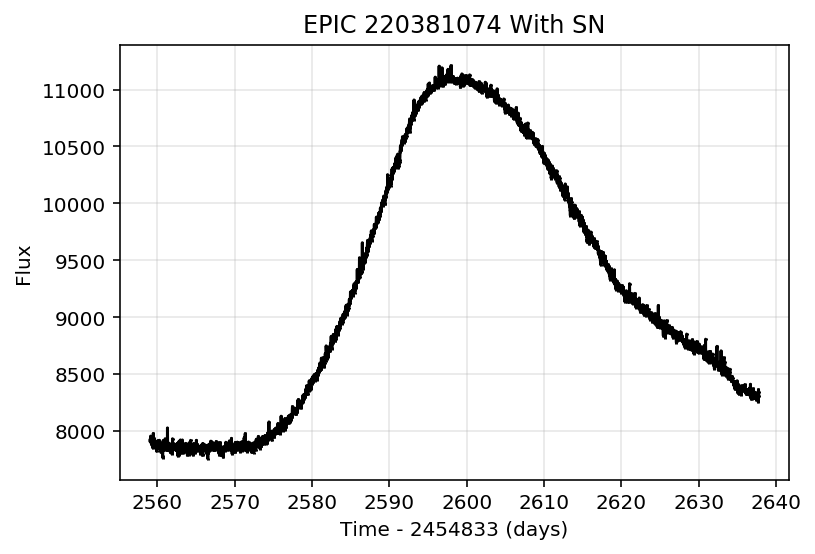

In [8]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

### Now attempt to "recover" the signal through fitting methods

Fitting methods include:
    - optimization (e.g. `scipy.optimize`)
    - MCMC sampling (e.g. `emcee`)
    
The goal at the end would be to compare the **True parameters**---that is, the values that were input to make the synthetic lightcurve--- with the *recovered parameters*, the ones that we derived from our fit.  We would call the signal "sucessfully" recovered if the *recovered parameters* match the True parameters to within either:
    - A fixed tolerance level, *or*
    - A threshold of estimated uncertainty of parameters (e.g. $>1\sigma$), both within the injected signal *and* above zero by some other threshold (e.g. $>3\sigma$). 
    
So for example, let's say we inject a supernova signal with an amplitude of $a = 15.0$ photons/sec. 

If we recover a signal with $a = 14\pm 2$, we would consider that injected signal to be "recovered".  

However, if we recover a signal with $a = 16\pm 20$, we would *not* consider that injected signal to be "recovered" because the signal is consistent with *zero* supernova, despite being consistent with the injected signal.

As another example, if we recover a signal with $a = 16\pm 5$, we *would* consider that injected signal to be "recovered" because the signal is just barely above our threshold of $3\sigma$.

The recovery of $a = 27\pm 1$ would disagree with our injected signal of $a = 15$, and therefore would *not* be considered a recovery.

In [9]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [10]:
%%time
T0_fit, z_fit, amplitude_fit, background_fit = lcinj.recover('Supernova', initial_guess=x0)

KeyboardInterrupt: 

We can a new SupernovaModel object with the fitted parameters and overplot it with the injected lightcurve:

In [ ]:
new_model = inj.SupernovaModel(T0=T0_fit, source='hsiao', bandpass='kepler', z=z_fit, amplitude=amplitude_fit)
new_fit = new_model.evaluate(lc.time) + background_fit

NameError: name 'new_fit' is not defined

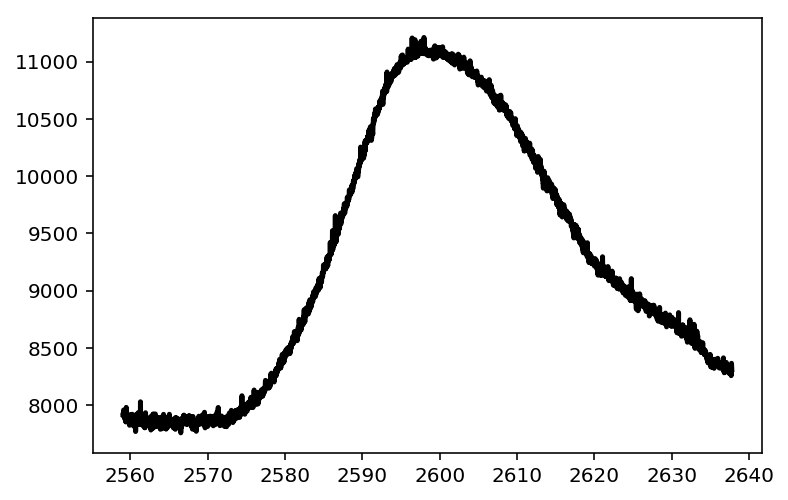

In [11]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

If we don't want to specify an initial guess, `.recover` will create a default initial guess.

In [12]:
T0_f, z_f, amplitude_f, background_f = lcinj.recover('Supernova')

KeyboardInterrupt: 

In [ ]:
new_model = inj.SupernovaModel(T0=T0_f, source='hsiao', bandpass='kepler', z=z_f, amplitude=amplitude_f)
new_fit = new_model.evaluate(lc.time) + background_f

In [ ]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

**Fitting supernovae with models that do not take amplitude: this is coming later.**

**TODO: figure out which values of z, x0, x1, and c (for SALT2 models) violate the Kepler bandpass.**

x0 = [2610, 0.5, 2.0e-3, 1.e-2, -.1, np.percentile(lc.flux, 3)]

%%time
T0_f, z_f, x0_f, x1_f, c_f, background_f = inj.recover(lcinj, 'Supernova', source='SALT2', initial_guess=x0)

new_model = inj.SupernovaModel(T0=T0_f, source='SALT2', bandpass='kepler', z=z_f, x0=x0_f, x1=x1_f, c=c_f)
new_fit = new_model.evaluate(lc.time) + background_f

# Fitting a Planetary Transit

Let's download a TPF and lightcurve of a G-type star from Kepler:

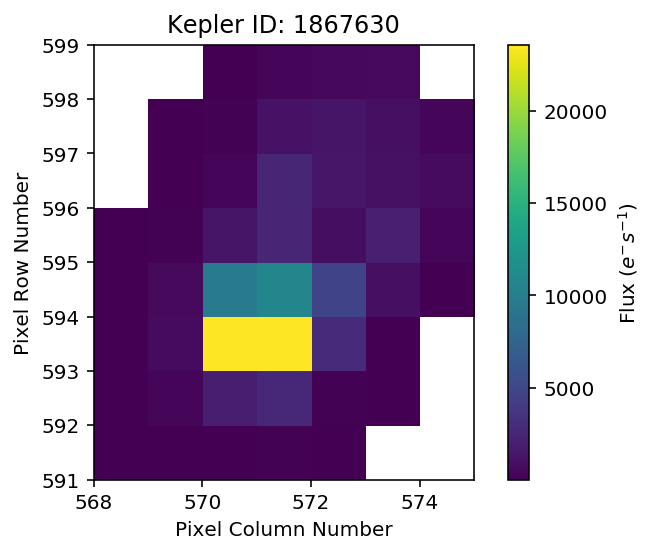

In [2]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

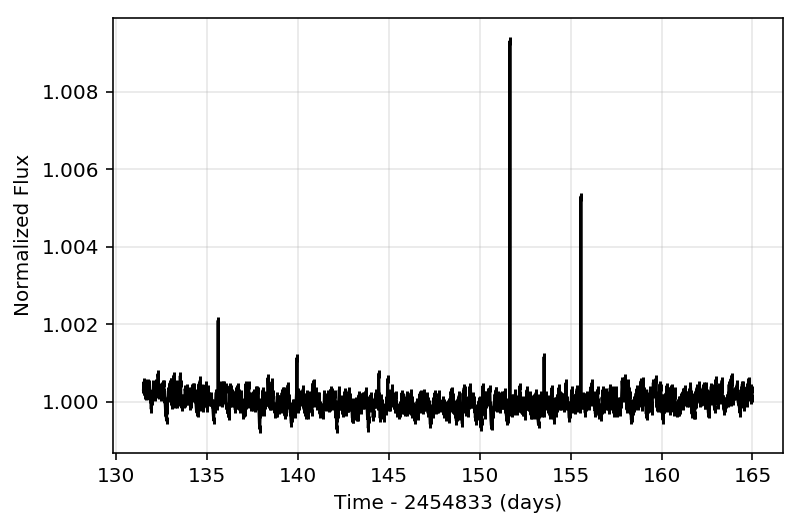

In [3]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

I am going to normalize this light curve, because we are multiplying in a normalized transit lightcurve.

Text(0.5,0,'Time (days)')

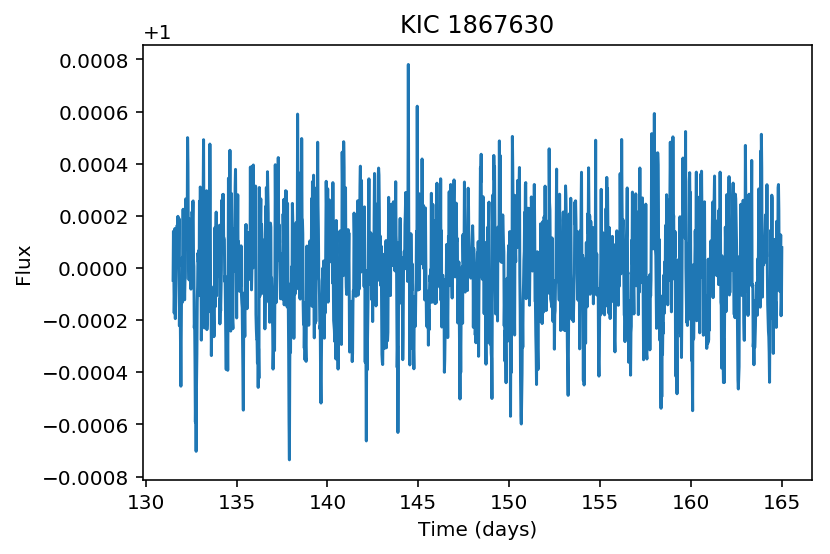

In [4]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize()
lc_star = lc_star.flatten()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm injecting a lightcurve of a Jupiter-sized planet with an orbital period of 5 days.

In [5]:
import batman
from lightkurve.injection import GaussianDistribution

In [6]:
model = inj.TransitModel()
model.add_planet(period=8, rprs=.07, T0=133)
lc_transit = lc_star.inject(model)

Let's plot just the model:

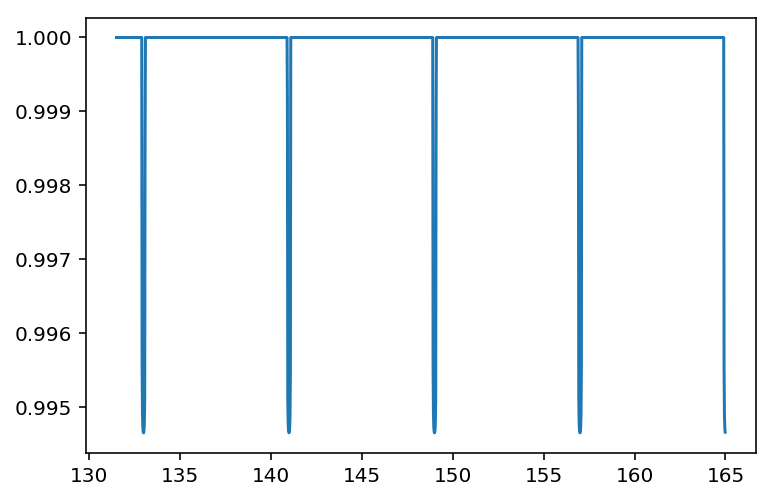

In [7]:
model_eval = model.evaluate(lc_star.time.astype(np.float))
plt.plot(lc_transit.time, model_eval)

And now the injected lightcurve:

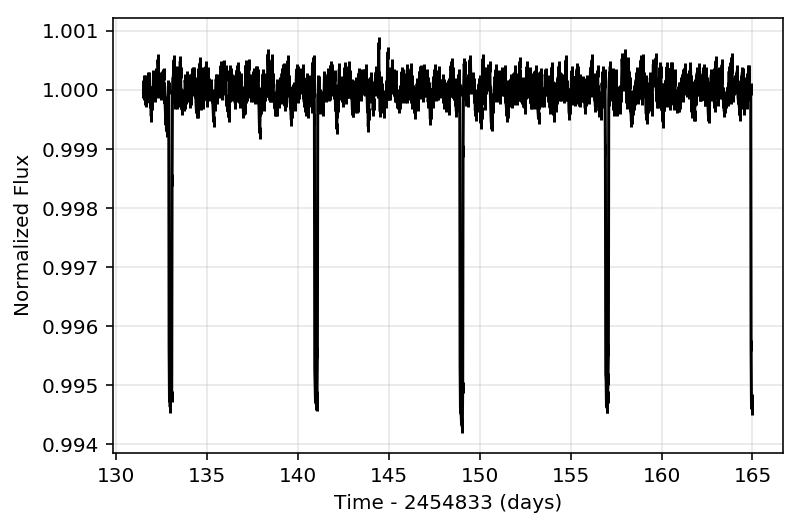

In [8]:
lc_transit.plot()

Now let's recover the transits using the `.recover` method with `signaltype = 'Planet'`.

In [9]:
%%time
period_fit, rprs_fit, T0_fit = lc_transit.recover('Planet')

CPU times: user 1.48 s, sys: 30.9 ms, total: 1.52 s
Wall time: 889 ms


In [10]:
print(period_fit, rprs_fit, T0_fit)

(7.999721342946786, 0.07004916734818935, 133.00048706230876)


Let's create a new model with these parameters and overplot with the injected signal.

In [11]:
model = inj.TransitModel()
model.add_planet(period=period_fit, T0=T0_fit, rprs=rprs_fit, a = 15, inc = 90, ecc = 0, w = 90, limb_dark = "nonlinear", u = [0.5, 0.1, 0.1, -0.1])

flux_fit = model.evaluate(lc_transit.time.astype(np.float))

Text(0,0.5,'Flux')

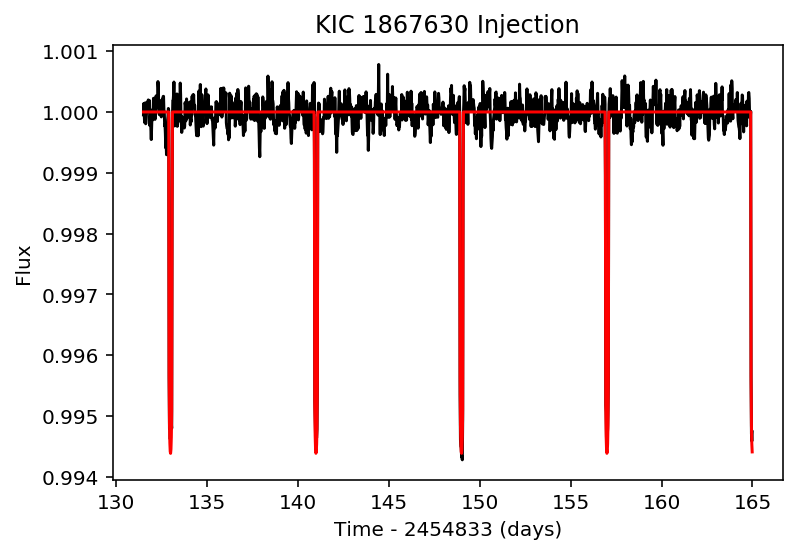

In [12]:
plt.plot(lc_transit.time, lc_transit.flux, color='k')
plt.plot(lc_transit.time, flux_fit, color='r')
plt.title('KIC 1867630 Injection')
plt.xlabel('Time - 2454833 (days)')
plt.ylabel('Flux')

# Now let's do an injection test

We're going to do our test on this G star:

In [149]:
from lightkurve.injection import GaussianDistribution, UniformDistribution

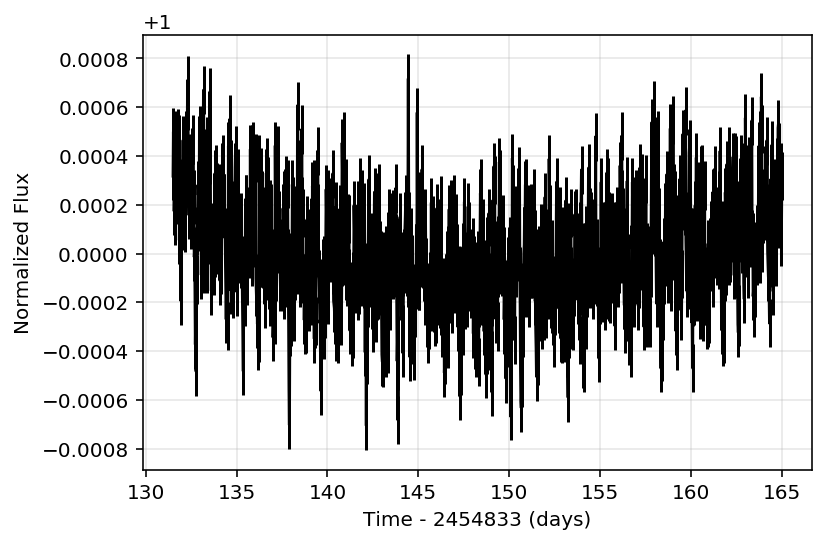

In [150]:
lc_star.plot()

And use these period, rprs, and T0 distributions (to sample randomly from):

In [162]:
period = UniformDistribution(1,10)
rprs = GaussianDistribution(0.03, 0.02)
T0 = UniformDistribution(1,6)

In [163]:
frac = inj.injrec_test(lc_star, signal_type='Planet', ntests=30, constr=0.03, period=period, rprs=rprs, T0=T0)

Recovered: 9.93018750252 0.0533661942782
1
Recovered: 3.94619943589 0.0330721663049
2
Recovered: 6.74916327811 0.0468573814271
3
Recovered: 9.46506430364 0.0686396602303
4
Recovered: 9.08448925798 0.0464313994128
5
Recovered: 7.20123673498 0.0458944596957
6
Recovered: 2.7259504726 0.0298398495353
7
Recovered: 4.71761819106 0.0417011592211
8
Recovered: 5.54179654796 0.0395282922314
9
Recovered: 3.78378914143 0.0263261625118
10
Recovered: 2.02204790743 0.0326592622386
11
Recovered: 9.19250410865 0.0610886751581
12
Recovered: 8.09168235013 0.0294881179899
13
Recovered: 7.52296460343 0.0338419683965
14
Recovered: 2.81562124757 0.0248518819407
15
Recovered: 6.59715781688 0.0554572053141
16
Recovered: 7.221969835 0.0315621858546
17
Recovered: 5.47233433418 0.0357023770587
18
Recovered: 5.64440106751 0.0487432950237
19
Recovered: 7.97648706437 0.0343393667645
20
Recovered: 7.13575519469 0.0247123622253
21


In [164]:
print(frac)

0.7


70% of the planets we tested are recovered using leastsq

# Work in progress: recovering multiple planets

What if we want to recover more than one planet?

In [609]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 134                   #time of inferior conjunction
params.per = 8                     #orbital period
params.rp = 0.07                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_2 = m.light_curve(params)

In [610]:
flux_mult = lc_star.flux * flux * flux_2

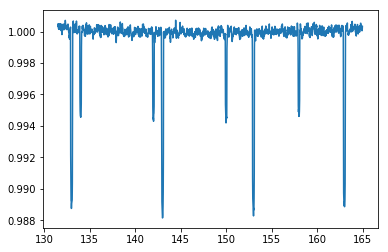

In [611]:
plt.plot(t, flux_mult)

In [612]:
from astropy.stats import BLS

In [613]:
model = BLS(t, flux_mult, dy=0.01)

In [614]:
periodogram = model.autopower(0.2)

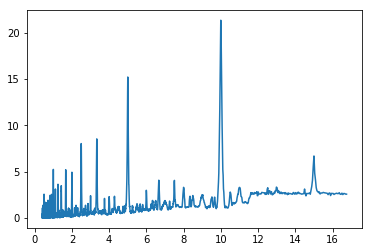

In [615]:
plt.plot(periodogram.period, periodogram.power)

Hmmmm.....

In [85]:
import lightkurve.injection as inj